# Análise de série temporal

In [1]:
# gerais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from datetime import datetime, timedelta
from typing import Tuple, Dict
import matplotlib.ticker as mtick
from itertools import product

In [2]:
# series temporais
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

In [3]:
df_mensal = pd.read_csv('../data/faturamento_2022_2025.csv', sep = ';', decimal = ',', encoding = 'latin1')

In [4]:
df_mensal['data'] = pd.to_datetime(df_mensal['data'])

In [5]:
df_mensal = df_mensal[~df_mensal['data'].between('2023-01-01', '2023-12-01')].reset_index(drop=True)

In [6]:
condicao = (df_mensal['data'].dt.year == 2022)

In [7]:
df_mensal.loc[condicao, 'data'] = df_mensal.loc[condicao, 'data'].apply(
    lambda date: date.replace(year=2023)
)

In [8]:
df = df_mensal.set_index('data')
df = df.asfreq('MS')

In [9]:
df['log_faturamento'] = np.log(df['faturamento'])

In [10]:
def create_month_dummies(df, months_to_track):
    """
    Cria colunas dummy (0 ou 1) para os meses especificados.
    :param df: DataFrame com índice temporal.
    :param months_to_track: Lista de meses (números 1 a 12). Ex: [3, 11, 12].
    :return: DataFrame com as novas colunas dummy.
    """
    df_with_dummies = df.copy()
    
    # 1. Extrair o mês do índice
    months = df.index.month
    
    for month in months_to_track:
        col_name = f'mes_{month}'
        # Cria a coluna, 1 se o mês for o especificado, 0 caso contrário
        df_with_dummies[col_name] = (months == month).astype(int)
        
    return df_with_dummies

In [11]:
MONTHS_OF_INTEREST = list(range(1, 13))
df = create_month_dummies(df, MONTHS_OF_INTEREST)

## Detecção da estacionariedade

In [12]:
teste_adf = adfuller(df['faturamento'])
print(f"Estatística ADF: {teste_adf[0]:.4f} (p-value: {teste_adf[1]:.4f})")

Estatística ADF: -4.2713 (p-value: 0.0005)


In [13]:
teste_adf = adfuller(df['log_faturamento'])
print(f"Estatística ADF: {teste_adf[0]:.4f} (p-value: {teste_adf[1]:.4f})")

Estatística ADF: -4.0774 (p-value: 0.0011)


## Identificação

- AR (p)

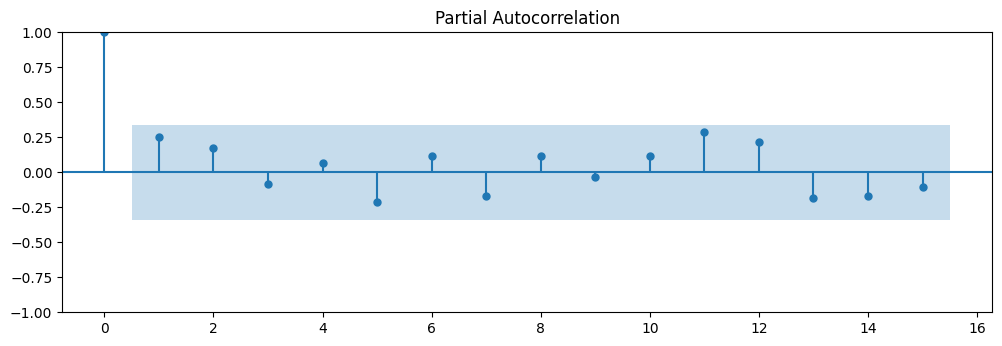

In [14]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_pacf(df['faturamento'], lags=15, ax=ax1)

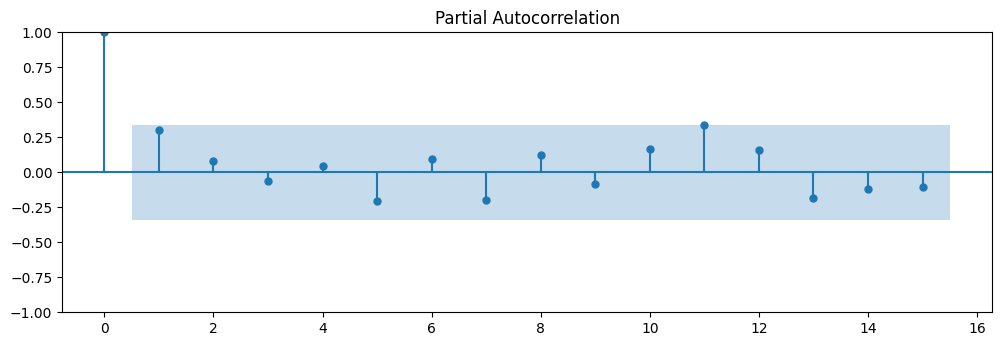

In [15]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_pacf(np.log(df['faturamento']), lags=15, ax=ax1)

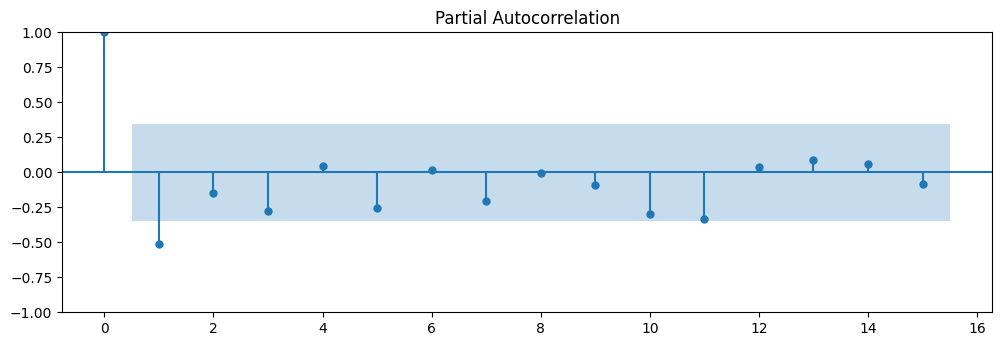

In [16]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_pacf(df['faturamento'].diff(1).dropna(), lags=15, ax=ax1)

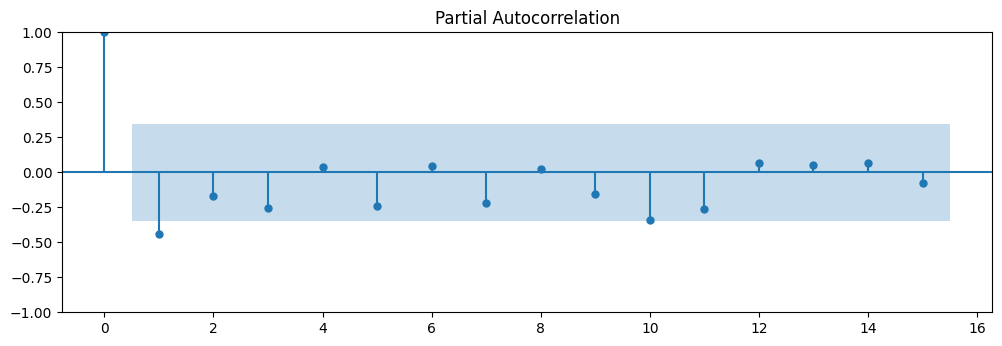

In [17]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_pacf(np.log(df['faturamento']).diff(1).dropna(), lags=15, ax=ax1)

- MA(q)

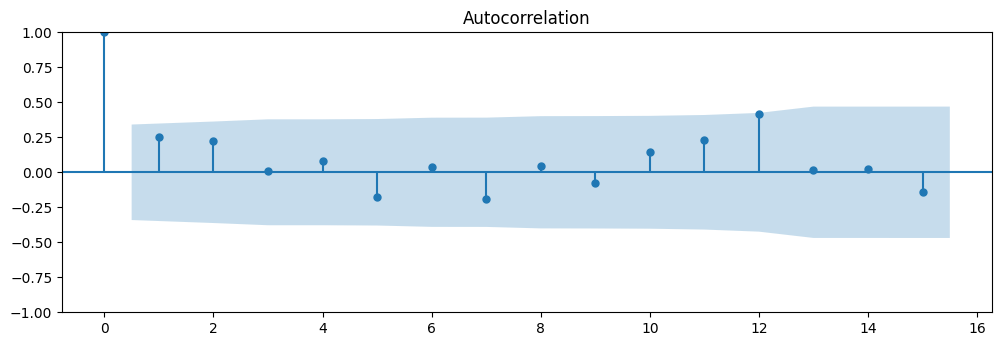

In [18]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df['faturamento'], lags=15, ax=ax1)

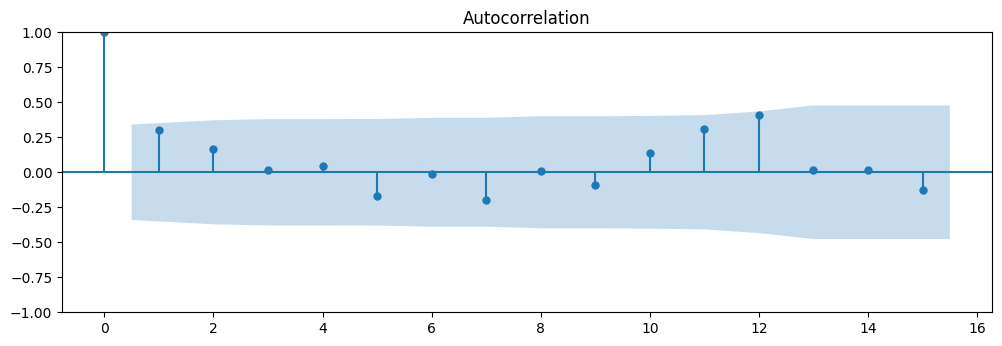

In [19]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(np.log(df['faturamento']), lags=15, ax=ax1)

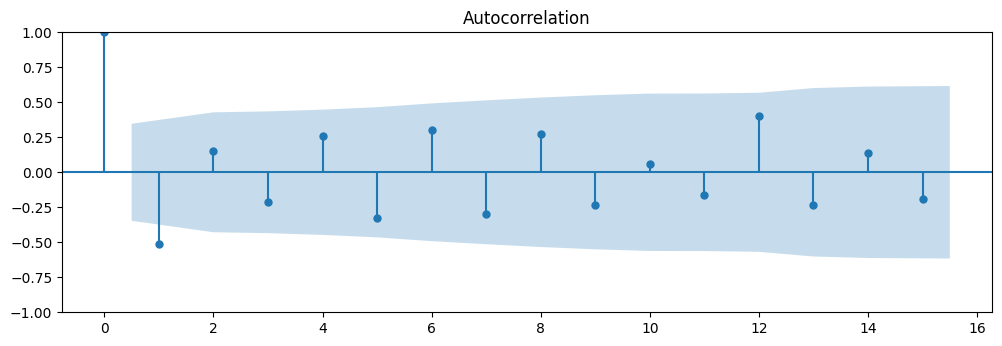

In [20]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df['faturamento'].diff(1).dropna(), lags=15, ax=ax1)

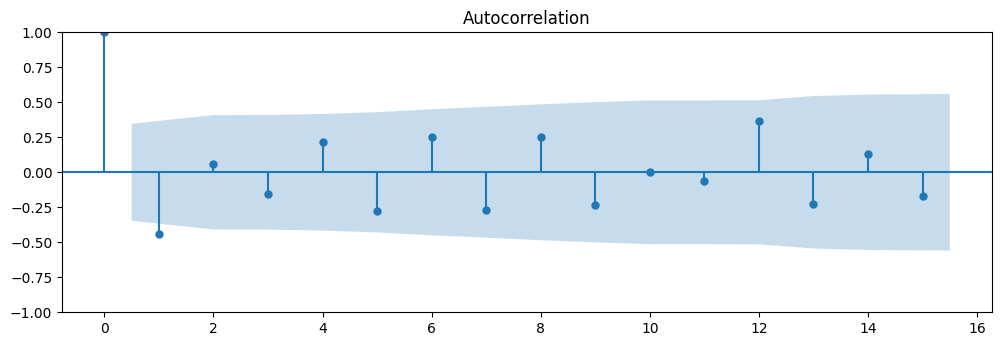

In [21]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(np.log(df['faturamento']).diff(1).dropna(), lags=15, ax=ax1)

## Modelo Box-Jenkins

(vamos tentar mesmo assim)

In [22]:
def create_sparse_mask(ar_lags=None, ma_lags=None, sar_lags=None, sma_lags=None):
    """
    Cria os arrays de máscara de atividade (1 ativo, 0 fixo em zero) 
    para os lags AR e MA com base nas listas fornecidas.

    :param ar_lags: Lista de lags AR que DEVEM SER ATIVOS (ex: [1, 10]).
    :param ma_lags: Lista de lags MA que DEVEM SER ATIVOS (ex: [1]).
    :return: Quatro arrays (AR, MA, SAR, SMA) com 1 para ativo e 0 para fixo em zero.
    """
    
    # 1. Determinar as ordens máximas (p e q)
    p = max(ar_lags) if ar_lags else 0
    q = max(ma_lags) if ma_lags else 0
    P = max(sar_lags) if sar_lags else 0
    Q = max(sma_lags) if sma_lags else 0
    
    # 2. Inicializar as máscaras com 0 (tudo inativo por padrão)
    ar_mask = np.zeros(p)
    ma_mask = np.zeros(q)
    sar_mask = np.zeros(P)
    sma_mask = np.zeros(Q)
    
    # 3. Marcar 1 nos lags que devem ser ATIVOS
    
    # Máscara AR
    if ar_lags:
        for lag in ar_lags:
            if lag > 0 and lag <= p:
                ar_mask[lag - 1] = 1 # O índice é lag - 1
                
    # Máscara MA
    if ma_lags:
        for lag in ma_lags:
            if lag > 0 and lag <= q:
                ma_mask[lag - 1] = 1
                
    # Máscaras Sazonais (mantidas em 0, pois você não as especificou como esparsas)
    
    return ar_mask, ma_mask, sar_mask, sma_mask

In [23]:
def build_sarimax_constraints(initial_model, ar_lags, ma_lags, num_exog=0):
    """
    Cria o dicionário de Kwargs para fixar em 0.0 os lags AR/MA indesejados, 
    garantindo que os parâmetros exógenos sejam estimados (não fixados).

    :param initial_model: Uma instância SARIMAX ajustada para obter os nomes dos parâmetros.
    :param ar_lags: Lista de lags AR ativos (ex: [1, 10]).
    :param ma_lags: Lista de lags MA ativos (ex: [1]).
    :param num_exog: Número de variáveis exógenas (len(exog_cols)).
    :return: Dicionário {nome_parametro: 0.0} para os lags fixos.
    """
    
    param_names = initial_model.param_names
    
    # 1. Definir o layout dos parâmetros no SARIMAX (aproximado):
    # [trend/const/intercept], [exog], [ar], [ma], [sar], [sma], [sigma2]
    
    # 2. Criar a máscara de status (1=Ativo, 0=Fixo em Zero)
    ar_mask_active, ma_mask_active, _, _ = create_sparse_mask(ar_lags, ma_lags)
    
    # 3. Mapear a máscara aos nomes dos parâmetros
    fixed_params_dict = {}
    current_idx = 0
    
    # --- Passo A: Pular Trend/Constante ---
    if param_names[current_idx] in ['const', 'trend', 'intercept']:
        current_idx += 1
        
    # --- Passo B: Pular Variáveis Exógenas ---
    # Os nomes dos parâmetros exógenos vêm logo após a constante.
    current_idx += num_exog
    
    # --- Passo C: Aplicar Máscara AR ---
    for i in range(len(ar_mask_active)):
        name = param_names[current_idx]
        if ar_mask_active[i] == 0:
            fixed_params_dict[name] = 0.0
        current_idx += 1
        
    # --- Passo D: Aplicar Máscara MA ---
    for i in range(len(ma_mask_active)):
        name = param_names[current_idx]
        if ma_mask_active[i] == 0:
            fixed_params_dict[name] = 0.0
        current_idx += 1
        
    # --- Passo E: Pular Sazonais e Sigma2 (variância) ---
    # O restante (SAR, SMA, Sigma2) não deve ser fixado em 0.0
    
    return fixed_params_dict

In [24]:
def train_sarimax(historico,
                  coluna_valor, 
                  include_constant = False,
                  order=(1, 1, 1), 
                  seasonal_order=(0, 0, 0, 0),
                  train_exog = None):
    
    model = SARIMAX(
        historico[coluna_valor],
        exog=train_exog,
        order=order,
        seasonal_order=seasonal_order,
        trend='c' if include_constant else 'n', 
        enforce_stationarity=False,
        enforce_invertibility=False
    )
            
    # Ajustar o modelo (fit)
    model_fit = model.fit(disp=False) # disp=False para não imprimir o log de convergência

    return model_fit

In [25]:
def train_sarimax_sparse(historico,
                         coluna_valor, 
                         include_constant = False,
                         ar_lags=[1, 10], 
                         ma_lags=[1], 
                         d=1,
                         seasonal_order=(0, 0, 0, 0),
                         train_exog = None):
    
    # 1. Definir a ordem p, q e as máscaras fixas para o loop
    p = max(ar_lags) if ar_lags else 0
    q = max(ma_lags) if ma_lags else 0
    order = (p, d, q)
    
    # Prepare sparse model
    prepare_model = SARIMAX(
        historico[coluna_valor],
        exog=train_exog,
        order=order,
        seasonal_order=seasonal_order,
        trend='c' if include_constant else 'n', 
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    num_exog = 0
    if train_exog is not None and not train_exog.empty:
        num_exog = train_exog.shape[1]
        
    fixed_params_dict = build_sarimax_constraints(prepare_model, ar_lags, ma_lags, num_exog)

    if not fixed_params_dict and (p > len(ar_lags) or q > len(ma_lags)):
         raise ValueError("A máscara de parâmetros não gerou restrições. Verifique ar_lags e ma_lags.")
    
    # 3. Ajustar o modelo usando a máscara
    model = SARIMAX(
        historico[coluna_valor],
        exog=train_exog,
        order=order,
        seasonal_order=seasonal_order,
        trend='c' if include_constant else 'n', 
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    
    # Se a string estiver vazia, significa que não há restrições (todos os lags são ativos até p)
    if not fixed_params_dict:
         raise ValueError("A máscara de parâmetros não gerou restrições. Verifique ar_lags e ma_lags.")

    model_fit = model.fit_constrained(disp=False, 
                                      constraints=fixed_params_dict, 
                                      method='lbfgs', maxiter=500)

    return model_fit

In [26]:
def rolling_forecast_sarimax(historico, coluna_valor, periodo_inicial, horizonte=1,
                             order=(1, 1, 1), seasonal_order=(0, 0, 0, 0),
                             sparse_model = False, exp_adjust = False,
                             include_constant = False,
                             exog_cols = None,
                             display_parameters = True):
    """
    Realiza a validação Walk-Forward (Rolling Forecast) usando o modelo SARIMAX.
    (Com suporte a modelos esparsos, variáveis exógenas e ajuste exponencial)
    """
    if periodo_inicial >= len(historico):
        raise ValueError("O período inicial deve ser menor que o tamanho do histórico.")

    previsoes = []
    reais = []
    indices_previstos = []

    # ------------------ INÍCIO DO LOOP DE ROLLING ------------------
    for i in range(periodo_inicial, len(historico) - horizonte + 1):
        
        # 1. Definir Treinamento e Real
        train = historico.iloc[:i]
        real_slice = historico.iloc[i : i + horizonte]
        
        # 1.1. Fatiar Variáveis Exógenas (se existirem)
        train_exog = None
        predict_exog = None
        if exog_cols:
            # Exógenas para o Treinamento
            train_exog = train[exog_cols]
            # Exógenas para a Previsão (os valores futuros)
            predict_exog = real_slice[exog_cols]
            
        # 2. Treinar o Modelo SARIMAX
        try:
            if sparse_model is False:
                model_fit = train_sarimax(train, coluna_valor,
                                          include_constant=include_constant,
                                          order=order, seasonal_order=seasonal_order,
                                          train_exog=train_exog)
            else:
                ar_lags, ma_lags, d = order
                model_fit = train_sarimax_sparse(train, coluna_valor,
                                                 include_constant=include_constant,
                                                 ar_lags=ar_lags,
                                                 ma_lags=ma_lags,
                                                 d=d,
                                                 seasonal_order=seasonal_order,
                                                 train_exog=train_exog)
            
            # 3. Gerar a Previsão
            idx_start = real_slice.index[0]
            idx_end = real_slice.index[-1]

            # print(idx_start, idx_end)
            # display(predict_exog)

            # A previsão deve receber o predict_exog se houver
            previsao_h = model_fit.predict(start=idx_start, end=idx_end, exog=predict_exog)
            
            previsoes.extend(previsao_h.tolist())
            reais.extend(real_slice[coluna_valor].tolist())
            indices_previstos.extend(real_slice.index.tolist())

            # print(reais)
            # print(previsoes)
            # print(indices_previstos)
            
        except Exception as e:
            print(f"Erro ao ajustar o SARIMAX no passo {i} (Treino até {train.index[-1]}): {e}")
            previsoes.extend([np.nan] * horizonte)
            reais.extend(real_slice[coluna_valor].tolist())
            indices_previstos.extend(real_slice.index.tolist())

    # ------------------ FIM DO LOOP DE ROLLING ------------------

    # --- 4. Avaliação das Métricas ---
    if display_parameters:
        display(model_fit.summary())
    
    if exp_adjust:
        # AVALIAÇÃO CORRETA: O exp() deve ser feito apenas nos arrays numpy
        previsoes = np.exp(np.array(previsoes))
        reais = np.exp(np.array(reais))
    else:
        previsoes = np.array(previsoes)
        reais = np.array(reais)
        
    # Recalculando o df_resultados com os arrays possivelmente transformados
    df_resultados = pd.DataFrame({
        'data': indices_previstos,
        'real': reais,
        'previsao': previsoes
    }).set_index('data').dropna()
    
    # ... (Cálculo das métricas MAE, RMSE, MAPE e retorno) ...
    reais_ = df_resultados['real'].values
    previsoes_ = df_resultados['previsao'].values

    mae = mean_absolute_error(reais_, previsoes_)
    rmse = np.sqrt(mean_squared_error(reais_, previsoes_))
    # Proteção contra divisão por zero para MAPE
    mape = np.mean(np.abs(reais_ - previsoes_) / np.maximum(np.abs(reais_), 1e-8)) * 100

    metrics = {"MAE": mae, "RMSE": rmse, "MAPE": mape}

    print(f"Rolling Forecast SARIMAX (h={horizonte}, Order={order}) -> MAE: {mae:,.2f} | RMSE: {rmse:,.2f} | MAPE: {mape:,.2f}%")
    
    return metrics, df_resultados

## Modelos

In [64]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [65]:
SCALE_FACTOR = 1_000_000

In [66]:
def format_currency_millions(x, pos):
    """Função para formatar valores do eixo Y como R$ X.X M."""
    x_real = x * SCALE_FACTOR
    if x_real >= 1e6:
        return f'R$ {x_real*1e-6:.1f}M'
    elif x_real >= 1e3:
        return f'R$ {x_real*1e-3:.1f}K'
    else:
        return f'R$ {x_real:,.0f}'

In [67]:
def format_currency_annotation(value):
    """Função para formatar valores em anotações (ex: R$ 33.4M)."""
    value_real = value * SCALE_FACTOR
    if value_real >= 1e6:
        return f'R$ {value_real*1e-6:.1f}M'
    else:
        return f'R$ {value_real:,.0f}'

In [68]:
def plot_forecast_results(historico_completo, df_resultados, coluna_valor, metricas, titulo="Série Temporal e Previsões"):
    """
    Gera um gráfico Matplotlib comparando Real vs. Previsto do Rolling Forecast
    """
    
    # 1. Preparação dos Dados
    
    # Historico completo (série de valores reais)
    df_real = historico_completo.reset_index()
    # print(df_real.columns)
    # df_real.columns = ['data', 'valor_real']

    # DataFrame de Previsões (apenas onde o forecast foi calculado)
    df_previsto = df_resultados.reset_index()
    df_previsto.columns = ['data', 'valor_real_previsto', 'previsao']
    
    
    # 2. Configuração do Plot
    fig, ax = plt.subplots(figsize=(12, 6))

    # --- 3. Plotagem do Valor Real ---
    ax.plot(
        df_real['data'], 
        df_real['valor_real'], 
        label=f'{coluna_valor.capitalize()} Real',
        marker='o', 
        linestyle='-', 
        color='C0'
    )

    # --- 4. Plotagem da Previsão ---
    # Plota a previsão a partir do primeiro ponto previsto
    ax.plot(
        df_previsto['data'], 
        df_previsto['previsao'], 
        label=f'{coluna_valor.capitalize()} Previsto',
        marker='o', 
        linestyle='--', # Linha tracejada para diferenciar
        color='red' 
    )
    
    # --- 5. Formatação dos Eixos ---
    
    # Eixo X (Datas)
    ax.set_xlabel("Data", fontsize=12)
    
    # Formatação de data (ajustar conforme a granularidade dos seus dados)
    # Se for mensal, podemos formatar como 'AAAA-MM'
    import matplotlib.dates as mdates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.tick_params(axis='x', rotation=45)
    
    # Eixo Y (Valores)
    ax.set_ylabel(coluna_valor.capitalize(), fontsize=12)
    formatter = mtick.FuncFormatter(format_currency_millions)
    ax.yaxis.set_major_formatter(formatter)
    
    # Título e Legendas
    ax.set_title(titulo, fontsize=14, fontweight='bold')
    ax.legend(loc='upper left', frameon=True)
    ax.grid(True, which='both', linestyle='-', linewidth=0.5)

    # Formatação do texto da métrica
    metrics_text = (
        f"Métricas de Erro:\n"
        f"MAE: {metricas.get('MAE', 0):,.2f}\n"
        f"RMSE: {metricas.get('RMSE', 0):,.2f}\n"
        f"MAPE: {metricas.get('MAPE', 0):,.2f}%"
    )
    
    # Adicionar o texto como um 'bbox' (bounding box) para destaque
    ax.text(
        0.98, 0.95, 
        metrics_text, 
        transform=ax.transAxes, # Usa coordenadas relativas (0 a 1)
        fontsize=10,
        verticalalignment='top',
        horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.6, edgecolor='black')
    )
    
    plt.tight_layout()
    plt.show()

In [69]:
coluna = 'faturamento'
coluna_log = 'log_faturamento'
periodo_treino_minimo = 24
horizonte_previsao = 3

# Seus parâmetros: AR(1 e 10), I(1), MA(1) -> Order=(10, 1, 1)
sarimax_order = (10, 1, 1) 
sarimax_seasonal = (0, 0, 0, 0)
sarimax_sparse_order = ([1, 10], [1], 1)
# EXOG_COLS = [f'mes_{m}' for m in [1, 2, 3, 11, 12]]
# EXOG_COLS = [f'mes_{m}' for m in [3, 11, 12]]

### ARIMA(10, 1, 1)

In [70]:
metricas_sarimax, df_resultados_sarimax = rolling_forecast_sarimax(
    df, 
    coluna, 
    periodo_treino_minimo, 
    horizonte=horizonte_previsao,
    order=sarimax_order,
    seasonal_order=sarimax_seasonal
)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            faturamento   No. Observations:                   30
Model:              SARIMAX(10, 1, 1)   Log Likelihood                 -15.478
Date:                Sat, 15 Nov 2025   AIC                             54.956
Time:                        13:48:38   BIC                             66.290
Sample:                    01-01-2023   HQIC                            56.875
                         - 06-01-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6864      1.059     -0.648      0.517      -2.761       1.388
ar.L2         -0.6232      0.583     -1.069      0.285      -1.766       0.519
ar.L3         -0.6809      0.455     -1.498      0.134      -1.572       0.210
ar.L4         -0.4614      0.970     -0.476      0.634      -2.362       1.439
ar.L5         -0.7245      1.803     -0.402      0.688      -4.259       2.810
ar.L6         -0.4854      0.320     -1.516      0.130      -1.113       0.142
ar.L7         -0.5843      1.262     -0.463      0.643      -3.057       1.889
ar.L8         -0.4922      0.810     -0.608      0.543      -2.080       1.096
ar.L9         -0.4444      0.382     -1.163      0.245      -1.193       0.304
ar.L10        -0.4959      1.030     -0.482      0.630      -2.514       1.522
ma.L1         -0.1627      0.920     -0.177      0.860      -1.965       1.640
sigma2         0.2982      0.133      2.249      0.025       0.038       0.558
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):                 3.72
Prob(Q):                              0.68   Prob(JB):                         0.16
Heteroskedasticity (H):               0.77   Skew:                             0.61
Prob(H) (two-sided):                  0.76   Kurtosis:                         4.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Rolling Forecast SARIMAX (h=3, Order=(10, 1, 1)) -> MAE: 0.62 | RMSE: 0.79 | MAPE: 19.67%


In [71]:
metricas_sarimax1, df_resultados_sarimax1 = rolling_forecast_sarimax(
    df, 
    coluna, 
    periodo_treino_minimo, 
    horizonte=1,
    order=sarimax_order,
    seasonal_order=sarimax_seasonal
)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            faturamento   No. Observations:                   32
Model:              SARIMAX(10, 1, 1)   Log Likelihood                 -16.110
Date:                Sat, 15 Nov 2025   AIC                             56.220
Time:                        13:48:39   BIC                             68.754
Sample:                    01-01-2023   HQIC                            58.940
                         - 08-01-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6754      0.803     -0.841      0.400      -2.250       0.899
ar.L2         -0.6315      0.513     -1.230      0.219      -1.637       0.374
ar.L3         -0.6718      0.356     -1.885      0.059      -1.370       0.027
ar.L4         -0.4549      0.803     -0.566      0.571      -2.029       1.119
ar.L5         -0.7255      1.591     -0.456      0.648      -3.845       2.394
ar.L6         -0.4870      0.302     -1.611      0.107      -1.080       0.106
ar.L7         -0.6197      0.858     -0.723      0.470      -2.300       1.061
ar.L8         -0.4617      0.526     -0.878      0.380      -1.492       0.569
ar.L9         -0.4530      0.333     -1.359      0.174      -1.106       0.200
ar.L10        -0.4724      0.857     -0.551      0.581      -2.152       1.207
ma.L1         -0.1480      0.812     -0.182      0.855      -1.739       1.443
sigma2         0.2713      0.104      2.608      0.009       0.067       0.475
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):                 5.90
Prob(Q):                              0.64   Prob(JB):                         0.05
Heteroskedasticity (H):               0.81   Skew:                             0.71
Prob(H) (two-sided):                  0.79   Kurtosis:                         5.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Rolling Forecast SARIMAX (h=1, Order=(10, 1, 1)) -> MAE: 0.56 | RMSE: 0.73 | MAPE: 18.29%


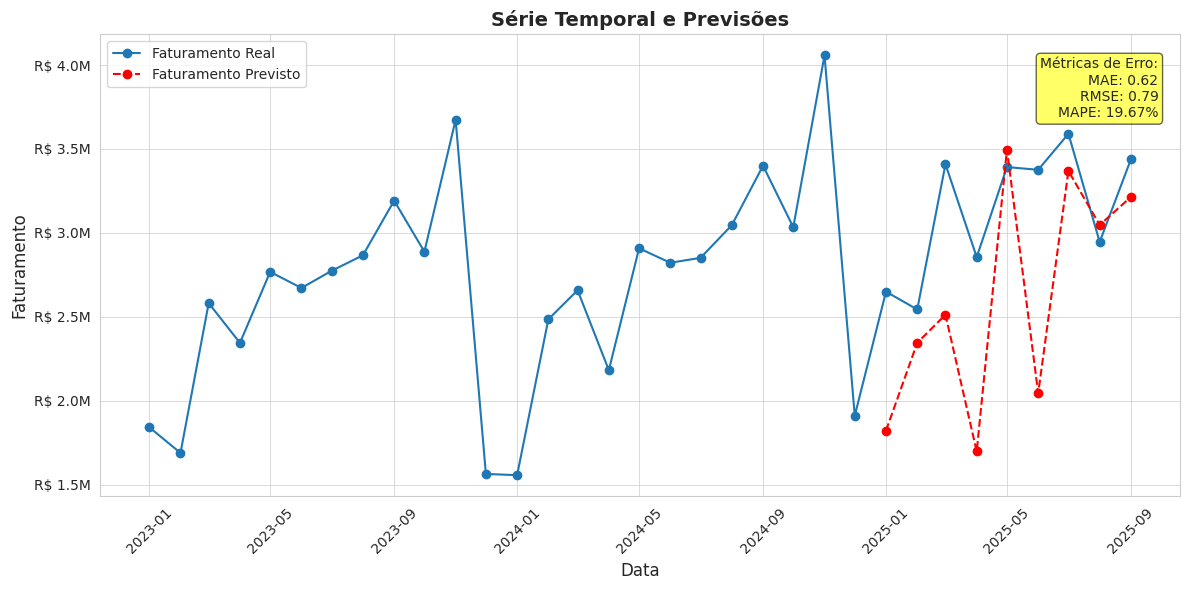

In [72]:
plot_forecast_results(
    df.rename(columns={coluna: 'valor_real'}),
    df_resultados_sarimax1,
    coluna,
    metricas_sarimax
)

### ARIMA(10, 1, 1) restrito

In [73]:
metricas_sarimax_sparse, df_resultados_sarimax_sparse = rolling_forecast_sarimax(
    df, 
    coluna, 
    periodo_treino_minimo, 
    horizonte=horizonte_previsao,
    order=sarimax_sparse_order,
    seasonal_order=sarimax_seasonal,
    sparse_model = True
)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            faturamento   No. Observations:                   30
Model:              SARIMAX(10, 1, 1)   Log Likelihood                 -19.600
Date:                Sat, 15 Nov 2025   AIC                             47.200
Time:                        13:48:42   BIC                             50.977
Sample:                    01-01-2023   HQIC                            47.839
                         - 06-01-2025                                         
Covariance Type:                  opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
ar.L1             0.0573      0.362      0.158      0.874      -0.652       0.766
ar.L2 (fixed)          0        nan        nan        nan         nan         nan
ar.L3 (fixed)          0        nan        nan        nan         nan         nan
ar.L4 (fixed)          0        nan        nan        nan         nan         nan
ar.L5 (fixed)          0        nan        nan        nan         nan         nan
ar.L6 (fixed)          0        nan        nan        nan         nan         nan
ar.L7 (fixed)          0        nan        nan        nan         nan         nan
ar.L8 (fixed)          0        nan        nan        nan         nan         nan
ar.L9 (fixed)          0        nan        nan        nan         nan         nan
ar.L10        -6.281e-06      0.189  -3.32e-05      1.000      -0.371       0.371
ma.L1            -0.8487      0.211     -4.028      0.000      -1.262      -0.436
sigma2            0.4434      0.159      2.794      0.005       0.132       0.754
===================================================================================
Ljung-Box (L1) (Q):                   0.20   Jarque-Bera (JB):                 2.62
Prob(Q):                              0.66   Prob(JB):                         0.27
Heteroskedasticity (H):               0.25   Skew:                            -0.89
Prob(H) (two-sided):                  0.12   Kurtosis:                         3.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1], 1)) -> MAE: 0.43 | RMSE: 0.49 | MAPE: 13.22%


In [74]:
metricas_sarimax_sparse1, df_resultados_sarimax_sparse1 = rolling_forecast_sarimax(
    df, 
    coluna, 
    periodo_treino_minimo, 
    horizonte=1,
    order=sarimax_sparse_order,
    seasonal_order=sarimax_seasonal,
    sparse_model = True
)

/home/alcides/projeto-timeseries/.env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            faturamento   No. Observations:                   32
Model:              SARIMAX(10, 1, 1)   Log Likelihood                 -21.570
Date:                Sat, 15 Nov 2025   AIC                             51.140
Time:                        13:48:43   BIC                             55.318
Sample:                    01-01-2023   HQIC                            52.047
                         - 08-01-2025                                         
Covariance Type:                  opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
ar.L1             0.0302      0.285      0.106      0.916      -0.528       0.588
ar.L2 (fixed)          0        nan        nan        nan         nan         nan
ar.L3 (fixed)          0        nan        nan        nan         nan         nan
ar.L4 (fixed)          0        nan        nan        nan         nan         nan
ar.L5 (fixed)          0        nan        nan        nan         nan         nan
ar.L6 (fixed)          0        nan        nan        nan         nan         nan
ar.L7 (fixed)          0        nan        nan        nan         nan         nan
ar.L8 (fixed)          0        nan        nan        nan         nan         nan
ar.L9 (fixed)          0        nan        nan        nan         nan         nan
ar.L10            0.0686      0.292      0.235      0.814      -0.503       0.640
ma.L1            -0.8244      0.178     -4.625      0.000      -1.174      -0.475
sigma2            0.4327      0.157      2.748      0.006       0.124       0.741
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):                 3.89
Prob(Q):                              0.63   Prob(JB):                         0.14
Heteroskedasticity (H):               0.27   Skew:                            -0.97
Prob(H) (two-sided):                  0.10   Kurtosis:                         3.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Rolling Forecast SARIMAX (h=1, Order=([1, 10], [1], 1)) -> MAE: 0.39 | RMSE: 0.44 | MAPE: 12.36%


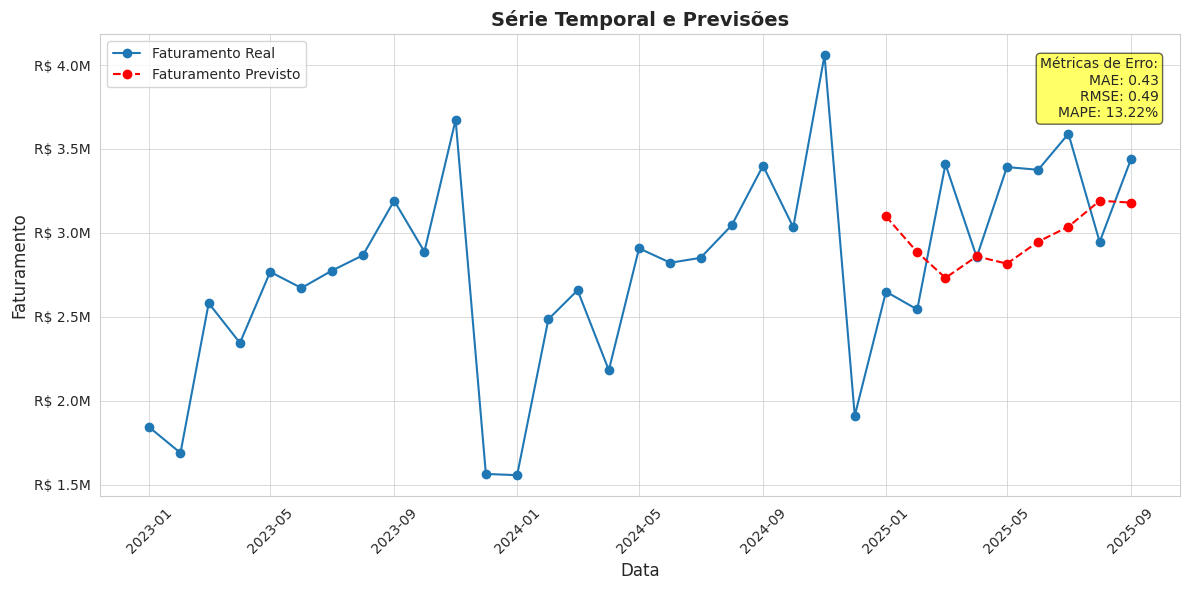

In [75]:
plot_forecast_results(
    df.rename(columns={coluna: 'valor_real'}),
    df_resultados_sarimax_sparse1,
    coluna,
    metricas_sarimax_sparse
)

### ARIMA(10, 1, 1) log

In [76]:
metricas_sarimax_log, df_resultados_sarimax_log = rolling_forecast_sarimax(
    df, 
    coluna_log, 
    periodo_treino_minimo, 
    horizonte=horizonte_previsao,
    order=sarimax_order,
    seasonal_order=sarimax_seasonal,
    exp_adjust = True
)

/home/alcides/projeto-timeseries/.env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        log_faturamento   No. Observations:                   30
Model:              SARIMAX(10, 1, 1)   Log Likelihood                   3.034
Date:                Sat, 15 Nov 2025   AIC                             17.933
Time:                        13:48:44   BIC                             29.266
Sample:                    01-01-2023   HQIC                            19.851
                         - 06-01-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6749      1.181     -0.572      0.568      -2.989       1.640
ar.L2         -0.6679      0.504     -1.324      0.186      -1.656       0.321
ar.L3         -0.6915      0.603     -1.148      0.251      -1.873       0.489
ar.L4         -0.4658      0.929     -0.501      0.616      -2.287       1.355
ar.L5         -0.7281      1.650     -0.441      0.659      -3.961       2.505
ar.L6         -0.4802      0.538     -0.892      0.373      -1.536       0.575
ar.L7         -0.6562      1.015     -0.646      0.518      -2.646       1.333
ar.L8         -0.4941      0.837     -0.590      0.555      -2.135       1.147
ar.L9         -0.4942      0.343     -1.442      0.149      -1.166       0.177
ar.L10        -0.5077      1.019     -0.498      0.618      -2.505       1.490
ma.L1         -0.0950      0.987     -0.096      0.923      -2.029       1.839
sigma2         0.0425      0.024      1.739      0.082      -0.005       0.090
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                 2.59
Prob(Q):                              0.72   Prob(JB):                         0.27
Heteroskedasticity (H):               0.66   Skew:                             0.26
Prob(H) (two-sided):                  0.63   Kurtosis:                         4.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Rolling Forecast SARIMAX (h=3, Order=(10, 1, 1)) -> MAE: 0.56 | RMSE: 0.73 | MAPE: 17.75%


In [77]:
metricas_sarimax_log1, df_resultados_sarimax_log1 = rolling_forecast_sarimax(
    df, 
    coluna_log, 
    periodo_treino_minimo, 
    horizonte=1,
    order=sarimax_order,
    seasonal_order=sarimax_seasonal,
    exp_adjust = True
)

/home/alcides/projeto-timeseries/.env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alcides/projeto-timeseries/.env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        log_faturamento   No. Observations:                   32
Model:              SARIMAX(10, 1, 1)   Log Likelihood                   4.404
Date:                Sat, 15 Nov 2025   AIC                             15.193
Time:                        13:48:45   BIC                             27.727
Sample:                    01-01-2023   HQIC                            17.913
                         - 08-01-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6723      1.086     -0.619      0.536      -2.800       1.455
ar.L2         -0.6659      0.461     -1.446      0.148      -1.569       0.237
ar.L3         -0.6903      0.548     -1.259      0.208      -1.765       0.385
ar.L4         -0.4652      0.856     -0.543      0.587      -2.143       1.213
ar.L5         -0.7275      1.531     -0.475      0.635      -3.728       2.273
ar.L6         -0.4784      0.491     -0.975      0.330      -1.440       0.483
ar.L7         -0.6510      0.926     -0.703      0.482      -2.467       1.165
ar.L8         -0.4915      0.753     -0.653      0.514      -1.967       0.984
ar.L9         -0.4934      0.318     -1.552      0.121      -1.117       0.130
ar.L10        -0.5091      0.924     -0.551      0.582      -2.320       1.302
ma.L1         -0.1016      0.901     -0.113      0.910      -1.867       1.664
sigma2         0.0385      0.019      1.984      0.047       0.000       0.076
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):                 4.65
Prob(Q):                              0.68   Prob(JB):                         0.10
Heteroskedasticity (H):               0.62   Skew:                             0.33
Prob(H) (two-sided):                  0.54   Kurtosis:                         5.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Rolling Forecast SARIMAX (h=1, Order=(10, 1, 1)) -> MAE: 0.51 | RMSE: 0.68 | MAPE: 16.44%


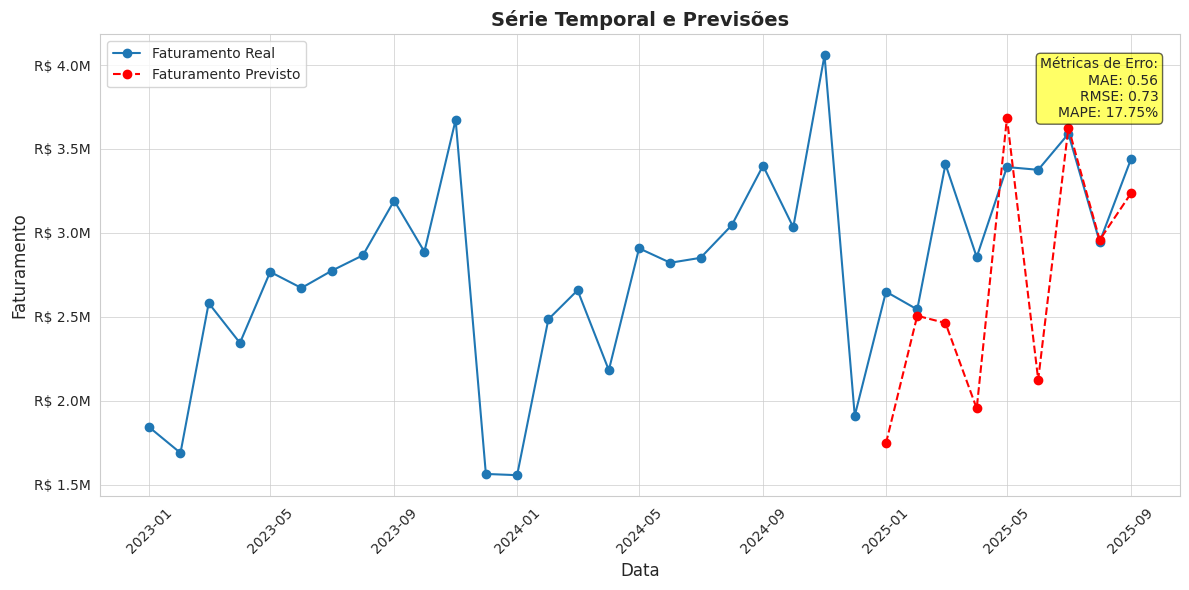

In [78]:
coluna = 'faturamento'
plot_forecast_results(
    df.rename(columns={coluna: 'valor_real'}),
    df_resultados_sarimax_log1,
    coluna,
    metricas_sarimax_log
)

### ARIMA(10, 1, 1) log restrito

In [79]:
metricas_sarimax_sparse_log, df_resultados_sarimax_sparse_log = rolling_forecast_sarimax(
    df, 
    coluna_log, 
    periodo_treino_minimo, 
    horizonte=horizonte_previsao,
    order=sarimax_sparse_order,
    seasonal_order=sarimax_seasonal,
    sparse_model = True,
    exp_adjust = True
)

/home/alcides/projeto-timeseries/.env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        log_faturamento   No. Observations:                   30
Model:              SARIMAX(10, 1, 1)   Log Likelihood                  -2.209
Date:                Sat, 15 Nov 2025   AIC                             12.417
Time:                        13:48:47   BIC                             16.195
Sample:                    01-01-2023   HQIC                            13.057
                         - 06-01-2025                                         
Covariance Type:                  opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
ar.L1             0.0872      0.306      0.285      0.776      -0.512       0.687
ar.L2 (fixed)          0        nan        nan        nan         nan         nan
ar.L3 (fixed)          0        nan        nan        nan         nan         nan
ar.L4 (fixed)          0        nan        nan        nan         nan         nan
ar.L5 (fixed)          0        nan        nan        nan         nan         nan
ar.L6 (fixed)          0        nan        nan        nan         nan         nan
ar.L7 (fixed)          0        nan        nan        nan         nan         nan
ar.L8 (fixed)          0        nan        nan        nan         nan         nan
ar.L9 (fixed)          0        nan        nan        nan         nan         nan
ar.L10            0.0422      0.297      0.142      0.887      -0.539       0.624
ma.L1            -0.8222      0.211     -3.901      0.000      -1.235      -0.409
sigma2            0.0696      0.027      2.579      0.010       0.017       0.123
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):                 7.08
Prob(Q):                              0.68   Prob(JB):                         0.03
Heteroskedasticity (H):               0.15   Skew:                            -1.38
Prob(H) (two-sided):                  0.03   Kurtosis:                         4.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1], 1)) -> MAE: 0.44 | RMSE: 0.52 | MAPE: 13.30%


In [80]:
metricas_sarimax_sparse_log1, df_resultados_sarimax_sparse_log1 = rolling_forecast_sarimax(
    df, 
    coluna_log, 
    periodo_treino_minimo, 
    horizonte=1,
    order=sarimax_sparse_order,
    seasonal_order=sarimax_seasonal,
    sparse_model = True,
    exp_adjust = True
)

/home/alcides/projeto-timeseries/.env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        log_faturamento   No. Observations:                   32
Model:              SARIMAX(10, 1, 1)   Log Likelihood                  -1.555
Date:                Sat, 15 Nov 2025   AIC                             11.111
Time:                        13:48:48   BIC                             15.289
Sample:                    01-01-2023   HQIC                            12.017
                         - 08-01-2025                                         
Covariance Type:                  opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
ar.L1             0.1069      0.282      0.378      0.705      -0.447       0.660
ar.L2 (fixed)          0        nan        nan        nan         nan         nan
ar.L3 (fixed)          0        nan        nan        nan         nan         nan
ar.L4 (fixed)          0        nan        nan        nan         nan         nan
ar.L5 (fixed)          0        nan        nan        nan         nan         nan
ar.L6 (fixed)          0        nan        nan        nan         nan         nan
ar.L7 (fixed)          0        nan        nan        nan         nan         nan
ar.L8 (fixed)          0        nan        nan        nan         nan         nan
ar.L9 (fixed)          0        nan        nan        nan         nan         nan
ar.L10            0.0769      0.267      0.288      0.774      -0.447       0.601
ma.L1            -0.8303      0.189     -4.404      0.000      -1.200      -0.461
sigma2            0.0642      0.022      2.868      0.004       0.020       0.108
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):                 8.48
Prob(Q):                              0.72   Prob(JB):                         0.01
Heteroskedasticity (H):               0.18   Skew:                            -1.38
Prob(H) (two-sided):                  0.04   Kurtosis:                         4.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Rolling Forecast SARIMAX (h=1, Order=([1, 10], [1], 1)) -> MAE: 0.36 | RMSE: 0.43 | MAPE: 10.98%


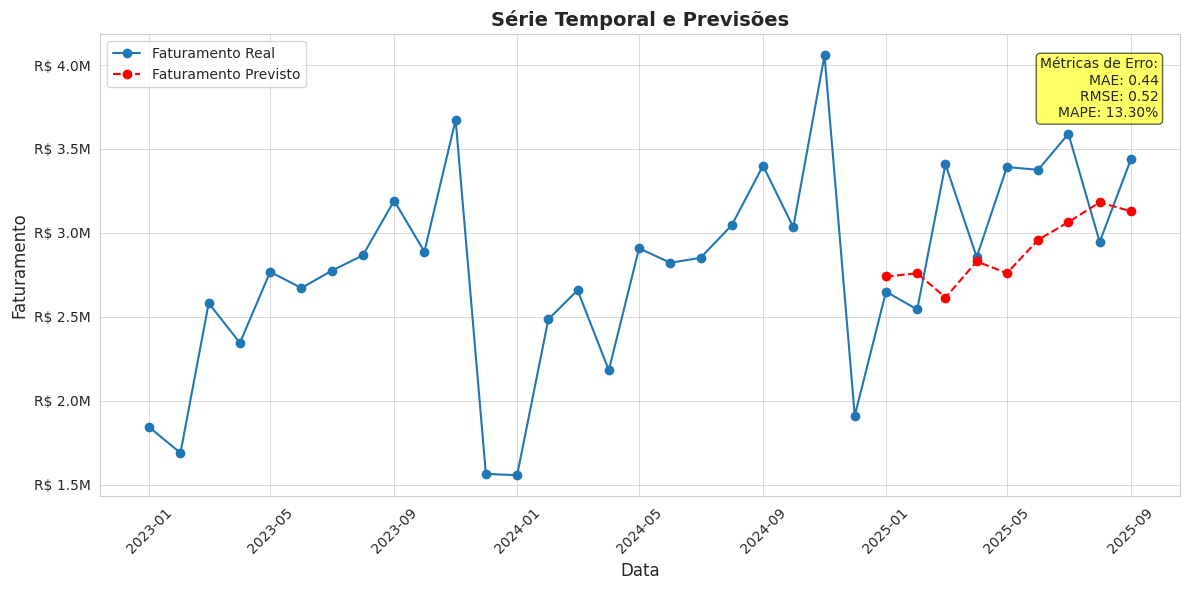

In [81]:
coluna = 'faturamento'
plot_forecast_results(
    df.rename(columns={coluna: 'valor_real'}),
    df_resultados_sarimax_sparse_log1,
    coluna,
    metricas_sarimax_sparse_log
)

### ARIMA(10, 1, 1) log restrito com endógenas

In [84]:
# [1, 10]	[1]	1	(1, 0, 0, 12)	[3]	
# [1, 5]	[1]	1	(1, 0, 0, 12)	
 # 0   [1, 10]  [1, 2]  1   (0, 0, 0, 0)          [1, 5]   7.306818  0.342479 

In [85]:
# sarimax_seasonal = (0, 0, 0, 0)

In [91]:
sarimax_sparse_order = ([1, 10], [1, 2], 1)
# EXOG_COLS = [f'mes_{m}' for m in [1, 2, 3, 11, 12]]
EXOG_COLS = [f'mes_{m}' for m in [1]]

In [92]:
metricas_sarimax_sparse_endog_log, df_resultados_sarimax_sparse_endog_log = rolling_forecast_sarimax(
    df, 
    coluna_log, 
    periodo_treino_minimo, 
    horizonte=3,
    order=sarimax_sparse_order,
    seasonal_order=sarimax_seasonal,
    sparse_model = True,
    exp_adjust = True,
    include_constant=False,
    exog_cols=EXOG_COLS
)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        log_faturamento   No. Observations:                   30
Model:              SARIMAX(10, 1, 2)   Log Likelihood                   5.358
Date:                Sat, 15 Nov 2025   AIC                              1.285
Time:                        13:50:13   BIC                              6.951
Sample:                    01-01-2023   HQIC                             2.244
                         - 06-01-2025                                         
Covariance Type:                  opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
mes_1            -0.6186      0.182     -3.397      0.001      -0.976      -0.262
ar.L1            -0.6930      0.168     -4.120      0.000      -1.023      -0.363
ar.L2 (fixed)          0        nan        nan        nan         nan         nan
ar.L3 (fixed)          0        nan        nan        nan         nan         nan
ar.L4 (fixed)          0        nan        nan        nan         nan         nan
ar.L5 (fixed)          0        nan        nan        nan         nan         nan
ar.L6 (fixed)          0        nan        nan        nan         nan         nan
ar.L7 (fixed)          0        nan        nan        nan         nan         nan
ar.L8 (fixed)          0        nan        nan        nan         nan         nan
ar.L9 (fixed)          0        nan        nan        nan         nan         nan
ar.L10            0.4017      0.177      2.266      0.023       0.054       0.749
ma.L1             0.1795   4836.426   3.71e-05      1.000   -9479.042    9479.401
ma.L2            -0.8205   3968.089     -0.000      1.000   -7778.133    7776.492
sigma2            0.0285    137.867      0.000      1.000    -270.186     270.243
===================================================================================
Ljung-Box (L1) (Q):                   0.73   Jarque-Bera (JB):                 2.04
Prob(Q):                              0.39   Prob(JB):                         0.36
Heteroskedasticity (H):               0.89   Skew:                             0.71
Prob(H) (two-sided):                  0.89   Kurtosis:                         3.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1, 2], 1)) -> MAE: 0.23 | RMSE: 0.35 | MAPE: 7.56%


In [93]:
metricas_sarimax_sparse_endog_log1, df_resultados_sarimax_sparse_endog_log1 = rolling_forecast_sarimax(
    df, 
    coluna_log, 
    periodo_treino_minimo, 
    horizonte=1,
    order=sarimax_sparse_order,
    seasonal_order=sarimax_seasonal,
    sparse_model = True,
    exp_adjust = True,
    include_constant=False,
    exog_cols=EXOG_COLS
)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        log_faturamento   No. Observations:                   32
Model:              SARIMAX(10, 1, 2)   Log Likelihood                   7.000
Date:                Sat, 15 Nov 2025   AIC                             -2.001
Time:                        13:50:14   BIC                              4.267
Sample:                    01-01-2023   HQIC                            -0.640
                         - 08-01-2025                                         
Covariance Type:                  opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
mes_1            -0.6207      0.163     -3.818      0.000      -0.939      -0.302
ar.L1            -0.7029      0.141     -4.981      0.000      -0.979      -0.426
ar.L2 (fixed)          0        nan        nan        nan         nan         nan
ar.L3 (fixed)          0        nan        nan        nan         nan         nan
ar.L4 (fixed)          0        nan        nan        nan         nan         nan
ar.L5 (fixed)          0        nan        nan        nan         nan         nan
ar.L6 (fixed)          0        nan        nan        nan         nan         nan
ar.L7 (fixed)          0        nan        nan        nan         nan         nan
ar.L8 (fixed)          0        nan        nan        nan         nan         nan
ar.L9 (fixed)          0        nan        nan        nan         nan         nan
ar.L10            0.3967      0.160      2.482      0.013       0.083       0.710
ma.L1             0.1769   1950.762   9.07e-05      1.000   -3823.247    3823.601
ma.L2            -0.8230   1605.746     -0.001      1.000   -3148.027    3146.381
sigma2            0.0260     50.679      0.001      1.000     -99.302      99.354
===================================================================================
Ljung-Box (L1) (Q):                   0.71   Jarque-Bera (JB):                 3.05
Prob(Q):                              0.40   Prob(JB):                         0.22
Heteroskedasticity (H):               0.09   Skew:                             0.77
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Rolling Forecast SARIMAX (h=1, Order=([1, 10], [1, 2], 1)) -> MAE: 0.29 | RMSE: 0.47 | MAPE: 10.30%


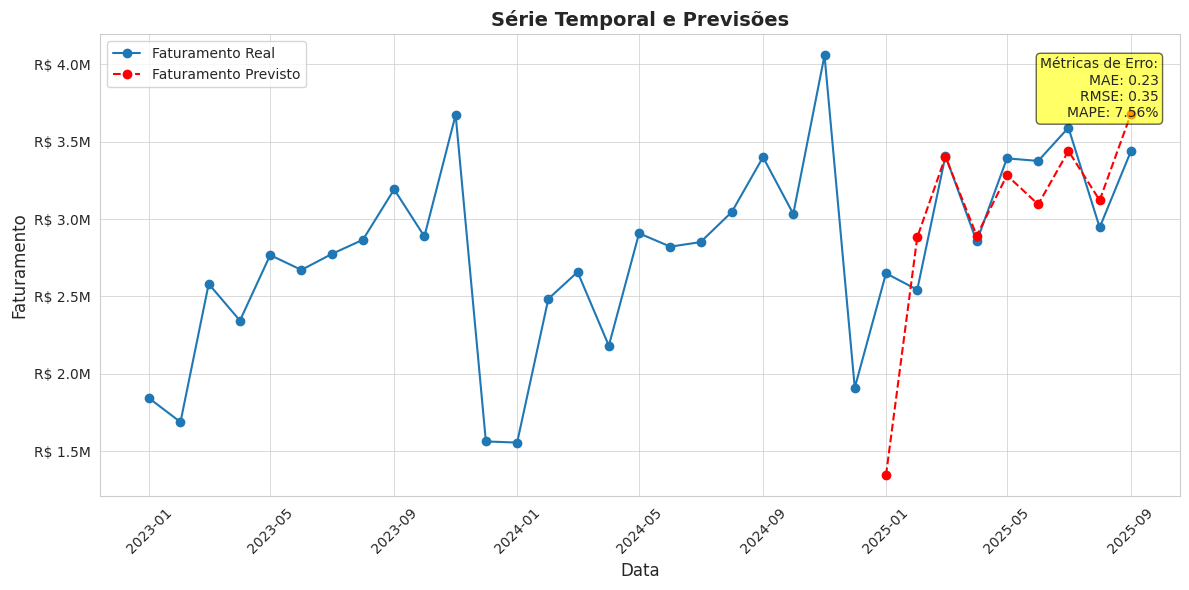

In [94]:
coluna = 'faturamento'
plot_forecast_results(
    df.rename(columns={coluna: 'valor_real'}),
    df_resultados_sarimax_sparse_endog_log1,
    coluna,
    metricas_sarimax_sparse_endog_log
)

In [95]:
df_resultados_sarimax_sparse_endog_log1

,real,previsao
data,,
2025-01-01,2.649523,1.345480
2025-02-01,2.543503,2.882209
2025-03-01,3.408972,3.403252
2025-04-01,2.855525,2.892057
2025-05-01,3.392261,3.282630
2025-06-01,3.375703,3.094888
2025-07-01,3.590566,3.439895
2025-08-01,2.945849,3.121323
2025-09-01,3.438343,3.679385


## Tunning

In [70]:
sarimax_sparse_order = ([1, 5], [1], 1)
# EXOG_COLS = [f'mes_{m}' for m in [1, 2, 3, 11, 12]]
EXOG_COLS = [f'mes_{m}' for m in [1]]

In [71]:
metricas_sarimax_sparse_endog_log, df_resultados_sarimax_sparse_endog_log = rolling_forecast_sarimax(
    df, 
    coluna_log, 
    periodo_treino_minimo, 
    horizonte=horizonte_previsao,
    order=sarimax_sparse_order,
    seasonal_order=sarimax_seasonal,
    sparse_model = True,
    exp_adjust = True,
    include_constant=False,
    exog_cols=EXOG_COLS
)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        log_faturamento   No. Observations:                   30
Model:               SARIMAX(5, 1, 1)   Log Likelihood                   4.238
Date:                Sat, 15 Nov 2025   AIC                              1.524
Time:                        13:25:38   BIC                              7.414
Sample:                    01-01-2023   HQIC                             3.087
                         - 06-01-2025                                         
Covariance Type:                  opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
mes_1            -0.6198      0.298     -2.078      0.038      -1.205      -0.035
ar.L1            -0.6287      0.463     -1.357      0.175      -1.537       0.279
ar.L2 (fixed)          0        nan        nan        nan         nan         nan
ar.L3 (fixed)          0        nan        nan        nan         nan         nan
ar.L4 (fixed)          0        nan        nan        nan         nan         nan
ar.L5            -0.0166      0.337     -0.049      0.961      -0.677       0.644
ma.L1            -0.6227      0.223     -2.793      0.005      -1.060      -0.186
sigma2            0.0403      0.017      2.399      0.016       0.007       0.073
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                11.50
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.67   Skew:                            -1.44
Prob(H) (two-sided):                  0.58   Kurtosis:                         4.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Rolling Forecast SARIMAX (h=3, Order=([1, 5], [1], 1)) -> MAE: 0.34 | RMSE: 0.46 | MAPE: 10.96%


In [59]:
def fine_tune_sarimax(historico, coluna_valor, periodo_inicial, horizonte,
                      ar_lags_options, ma_lags_options, d_options, seasonal_options, exog_options):
    """
    Realiza um Grid Search para encontrar a melhor combinação de parâmetros SARIMAX esparsos e exógenas.
    """
    
    # Desabilita a exibição do summary a cada iteração
    display_parameters = False 
    
    # 1. Preparação para o Grid Search
    
    # Cria o grid completo de combinações (produto cartesiano)
    param_grid = list(product(ar_lags_options, ma_lags_options, d_options, seasonal_options, exog_options))
    
    results = []
    
    print(f"Iniciando Grid Search com {len(param_grid)} combinações...")
    
    # 2. Loop sobre o Grid
    for ar_lags, ma_lags, d, seasonal_order, months_exog in param_grid:
        
        try:
            # 2.1. Configuração do Modelo
            
            # A ordem é necessária para a função rolling_forecast_sarimax
            order = (ar_lags, ma_lags, d)
            
            # Variáveis Exógenas
            exog_cols = [f'mes_{m}' for m in months_exog]
            
            # Se houver exógenas, o histórico deve ser preparado
            if exog_cols:
                # Função auxiliar para criar as dummies (deve estar definida)
                df_temp = create_month_dummies(historico, months_exog) 
            else:
                df_temp = historico.copy()
            
            # 2.2. Execução do Rolling Forecast
            
            metrics, _ = rolling_forecast_sarimax(
                df_temp, 
                coluna_valor, 
                periodo_inicial, 
                horizonte,
                order=order, 
                seasonal_order=seasonal_order,
                sparse_model=True,  # Força o uso do modelo esparso
                include_constant=False,
                exog_cols=exog_cols,
                exp_adjust = True,
                display_parameters=display_parameters
            )
            
            # 2.3. Armazenamento dos Resultados
            
            results.append({
                'ar_lags': ar_lags,
                'ma_lags': ma_lags,
                'd': d,
                'seasonal_order': seasonal_order,
                'exog_months': months_exog,
                'MAPE': metrics['MAPE'],
                'RMSE': metrics['RMSE'],
                'MAE': metrics['MAE']
            })
            
        except Exception as e:
            # Captura falhas de ajuste do modelo (comum no SARIMAX)
            print(f"Falha na combinação AR={ar_lags}, MA={ma_lags}, D={d}, Exog={months_exog}: {e}")
            results.append({
                'ar_lags': ar_lags,
                'ma_lags': ma_lags,
                'd': d,
                'seasonal_order': seasonal_order,
                'exog_months': months_exog,
                'MAPE': np.nan, 'RMSE': np.nan, 'MAE': np.nan
            })

    # 3. Análise dos Resultados
    df_results = pd.DataFrame(results).sort_values(by='MAPE', ascending=True).reset_index(drop=True)
    
    best_model = df_results.iloc[0]
    
    print("\n--- MELHOR MODELO ENCONTRADO ---")
    print(f"MAPE Mínimo: {best_model['MAPE']:.2f}%")
    print(f"AR Lags: {best_model['ar_lags']}")
    print(f"MA Lags: {best_model['ma_lags']}")
    print(f"I: {best_model['d']}")
    print(f"Sazonal: {best_model['seasonal_order']}")
    print(f"Exógenas: {best_model['exog_months']}")
    
    return df_results, best_model

In [63]:
# DEFINIÇÃO DO GRID
AR_LAGS_OPTIONS = [[1], [1, 5], [1, 10]]
MA_LAGS_OPTIONS = [[1], [1, 2]]
D_OPTIONS = [1]
SEASONAL_OPTIONS = [(0, 0, 0, 0), (1, 0, 0, 12)]
EXOG_OPTIONS = [[], [1], [3], [1, 3], [1, 5], [1, 3, 11, 12]]

# EXECUÇÃO
df_tuning_results, melhor_modelo = fine_tune_sarimax(
    historico=df,
    coluna_valor='log_faturamento',
    periodo_inicial=periodo_treino_minimo,
    horizonte=3,
    ar_lags_options=AR_LAGS_OPTIONS,
    ma_lags_options=MA_LAGS_OPTIONS,
    d_options=D_OPTIONS,
    seasonal_options=SEASONAL_OPTIONS,
    exog_options=EXOG_OPTIONS
)

Iniciando Grid Search com 72 combinações...
Erro ao ajustar o SARIMAX no passo 24 (Treino até 2024-12-01 00:00:00): A máscara de parâmetros não gerou restrições. Verifique ar_lags e ma_lags.
Erro ao ajustar o SARIMAX no passo 25 (Treino até 2025-01-01 00:00:00): A máscara de parâmetros não gerou restrições. Verifique ar_lags e ma_lags.
Erro ao ajustar o SARIMAX no passo 26 (Treino até 2025-02-01 00:00:00): A máscara de parâmetros não gerou restrições. Verifique ar_lags e ma_lags.
Erro ao ajustar o SARIMAX no passo 27 (Treino até 2025-03-01 00:00:00): A máscara de parâmetros não gerou restrições. Verifique ar_lags e ma_lags.
Erro ao ajustar o SARIMAX no passo 28 (Treino até 2025-04-01 00:00:00): A máscara de parâmetros não gerou restrições. Verifique ar_lags e ma_lags.
Erro ao ajustar o SARIMAX no passo 29 (Treino até 2025-05-01 00:00:00): A máscara de parâmetros não gerou restrições. Verifique ar_lags e ma_lags.
Erro ao ajustar o SARIMAX no passo 30 (Treino até 2025-06-01 00:00:00): A 

/home/alcides/projeto-timeseries/.env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Rolling Forecast SARIMAX (h=3, Order=([1, 5], [1], 1)) -> MAE: 0.49 | RMSE: 0.55 | MAPE: 14.80%
Rolling Forecast SARIMAX (h=3, Order=([1, 5], [1], 1)) -> MAE: 0.34 | RMSE: 0.46 | MAPE: 10.96%
Rolling Forecast SARIMAX (h=3, Order=([1, 5], [1], 1)) -> MAE: 0.50 | RMSE: 0.55 | MAPE: 15.43%
Rolling Forecast SARIMAX (h=3, Order=([1, 5], [1], 1)) -> MAE: 0.37 | RMSE: 0.48 | MAPE: 12.14%
Rolling Forecast SARIMAX (h=3, Order=([1, 5], [1], 1)) -> MAE: 0.35 | RMSE: 0.47 | MAPE: 11.11%
Rolling Forecast SARIMAX (h=3, Order=([1, 5], [1], 1)) -> MAE: 0.48 | RMSE: 0.63 | MAPE: 15.66%


/home/alcides/projeto-timeseries/.env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Rolling Forecast SARIMAX (h=3, Order=([1, 5], [1], 1)) -> MAE: 0.58 | RMSE: 0.78 | MAPE: 18.84%
Rolling Forecast SARIMAX (h=3, Order=([1, 5], [1], 1)) -> MAE: 0.39 | RMSE: 0.50 | MAPE: 13.01%


/home/alcides/projeto-timeseries/.env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Rolling Forecast SARIMAX (h=3, Order=([1, 5], [1], 1)) -> MAE: 1.05 | RMSE: 1.79 | MAPE: 33.18%


/home/alcides/projeto-timeseries/.env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alcides/projeto-timeseries/.env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Rolling Forecast SARIMAX (h=3, Order=([1, 5], [1], 1)) -> MAE: 0.57 | RMSE: 0.73 | MAPE: 18.28%


/home/alcides/projeto-timeseries/.env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Rolling Forecast SARIMAX (h=3, Order=([1, 5], [1], 1)) -> MAE: 0.44 | RMSE: 0.57 | MAPE: 14.21%


/home/alcides/projeto-timeseries/.env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Rolling Forecast SARIMAX (h=3, Order=([1, 5], [1], 1)) -> MAE: 0.64 | RMSE: 0.78 | MAPE: 20.10%
Rolling Forecast SARIMAX (h=3, Order=([1, 5], [1, 2], 1)) -> MAE: 0.43 | RMSE: 0.53 | MAPE: 13.12%
Rolling Forecast SARIMAX (h=3, Order=([1, 5], [1, 2], 1)) -> MAE: 0.39 | RMSE: 0.51 | MAPE: 12.47%
Rolling Forecast SARIMAX (h=3, Order=([1, 5], [1, 2], 1)) -> MAE: 0.48 | RMSE: 0.53 | MAPE: 14.63%
Rolling Forecast SARIMAX (h=3, Order=([1, 5], [1, 2], 1)) -> MAE: 0.38 | RMSE: 0.48 | MAPE: 12.18%


/home/alcides/projeto-timeseries/.env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Rolling Forecast SARIMAX (h=3, Order=([1, 5], [1, 2], 1)) -> MAE: 0.35 | RMSE: 0.44 | MAPE: 11.29%
Rolling Forecast SARIMAX (h=3, Order=([1, 5], [1, 2], 1)) -> MAE: 0.41 | RMSE: 0.53 | MAPE: 13.65%


/tmp/ipykernel_2866/121405788.py:83: RuntimeWarning: overflow encountered in exp
  previsoes = np.exp(np.array(previsoes))


Falha na combinação AR=[1, 5], MA=[1, 2], D=1, Exog=[]: Input contains infinity or a value too large for dtype('float64').


/home/alcides/projeto-timeseries/.env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Rolling Forecast SARIMAX (h=3, Order=([1, 5], [1, 2], 1)) -> MAE: 0.49 | RMSE: 0.57 | MAPE: 16.17%
Rolling Forecast SARIMAX (h=3, Order=([1, 5], [1, 2], 1)) -> MAE: 52.08 | RMSE: 222.90 | MAPE: 1,807.79%


/home/alcides/projeto-timeseries/.env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alcides/projeto-timeseries/.env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Rolling Forecast SARIMAX (h=3, Order=([1, 5], [1, 2], 1)) -> MAE: 63.71 | RMSE: 282.32 | MAPE: 2,222.31%
Rolling Forecast SARIMAX (h=3, Order=([1, 5], [1, 2], 1)) -> MAE: 0.61 | RMSE: 0.73 | MAPE: 19.67%


/home/alcides/projeto-timeseries/.env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alcides/projeto-timeseries/.env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Rolling Forecast SARIMAX (h=3, Order=([1, 5], [1, 2], 1)) -> MAE: 0.75 | RMSE: 0.98 | MAPE: 23.35%


/home/alcides/projeto-timeseries/.env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1], 1)) -> MAE: 0.44 | RMSE: 0.52 | MAPE: 13.30%
Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1], 1)) -> MAE: 0.33 | RMSE: 0.47 | MAPE: 10.85%


/home/alcides/projeto-timeseries/.env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1], 1)) -> MAE: 0.42 | RMSE: 0.49 | MAPE: 12.61%
Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1], 1)) -> MAE: 0.30 | RMSE: 0.40 | MAPE: 10.12%
Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1], 1)) -> MAE: 0.33 | RMSE: 0.47 | MAPE: 10.85%
Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1], 1)) -> MAE: 0.46 | RMSE: 0.60 | MAPE: 15.15%


/home/alcides/projeto-timeseries/.env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1], 1)) -> MAE: 0.34 | RMSE: 0.40 | MAPE: 11.16%


/home/alcides/projeto-timeseries/.env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alcides/projeto-timeseries/.env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alcides/projeto-timeseries/.env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1], 1)) -> MAE: 0.50 | RMSE: 0.58 | MAPE: 15.90%


/home/alcides/projeto-timeseries/.env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1], 1)) -> MAE: 0.37 | RMSE: 0.42 | MAPE: 11.72%


/home/alcides/projeto-timeseries/.env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alcides/projeto-timeseries/.env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1], 1)) -> MAE: 0.50 | RMSE: 0.76 | MAPE: 15.69%


/home/alcides/projeto-timeseries/.env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alcides/projeto-timeseries/.env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1], 1)) -> MAE: 0.47 | RMSE: 0.55 | MAPE: 15.12%
Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1], 1)) -> MAE: 0.61 | RMSE: 0.80 | MAPE: 18.69%
Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1, 2], 1)) -> MAE: 0.46 | RMSE: 0.54 | MAPE: 13.95%
Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1, 2], 1)) -> MAE: 0.23 | RMSE: 0.35 | MAPE: 7.56%


/home/alcides/projeto-timeseries/.env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1, 2], 1)) -> MAE: 0.47 | RMSE: 0.55 | MAPE: 14.40%
Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1, 2], 1)) -> MAE: 0.28 | RMSE: 0.44 | MAPE: 9.00%
Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1, 2], 1)) -> MAE: 0.22 | RMSE: 0.34 | MAPE: 7.31%
Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1, 2], 1)) -> MAE: 0.46 | RMSE: 0.55 | MAPE: 14.98%


/home/alcides/projeto-timeseries/.env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1, 2], 1)) -> MAE: 0.35 | RMSE: 0.41 | MAPE: 11.42%
Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1, 2], 1)) -> MAE: 0.50 | RMSE: 0.57 | MAPE: 15.87%


/home/alcides/projeto-timeseries/.env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alcides/projeto-timeseries/.env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1, 2], 1)) -> MAE: 0.36 | RMSE: 0.41 | MAPE: 11.64%


/home/alcides/projeto-timeseries/.env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1, 2], 1)) -> MAE: 0.43 | RMSE: 0.49 | MAPE: 13.44%


/home/alcides/projeto-timeseries/.env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alcides/projeto-timeseries/.env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alcides/projeto-timeseries/.env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1, 2], 1)) -> MAE: 0.47 | RMSE: 0.54 | MAPE: 15.05%


/home/alcides/projeto-timeseries/.env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1, 2], 1)) -> MAE: 0.72 | RMSE: 1.02 | MAPE: 22.10%

--- MELHOR MODELO ENCONTRADO ---
MAPE Mínimo: 7.31%
AR Lags: [1, 10]
MA Lags: [1, 2]
I: 1
Sazonal: (0, 0, 0, 0)
Exógenas: [1, 5]
